<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.3%20The%20U.S.%20Stock%20Market%20Through%20Time/Section%202.3.3%20Recessions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing yfinance and arch...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

Installing yfinance and arch...


In [2]:
# get the daily returns of the S&P 500 
print("Getting the data...")
SPX=download('^GSPC','1928-01-03').dropna()
SPX['Return']=SPX['Adj Close'].pct_change()*hundred
SPX.index=pd.DatetimeIndex(SPX.index).to_period('B')
SPX.dropna(inplace=True)
SPX.loc[SPX["Volume"]==0,"Volume"]=np.nan
SPX

Getting the data...
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
1928-01-04,17.719999,17.719999,17.719999,17.719999,17.719999,NaN,-0.225230
1928-01-05,17.549999,17.549999,17.549999,17.549999,17.549999,NaN,-0.959368
1928-01-06,17.660000,17.660000,17.660000,17.660000,17.660000,NaN,0.626784
1928-01-09,17.500000,17.500000,17.500000,17.500000,17.500000,NaN,-0.906001
1928-01-10,17.370001,17.370001,17.370001,17.370001,17.370001,NaN,-0.742852
...,...,...,...,...,...,...,...
2023-05-18,4157.680176,4202.200195,4153.500000,4198.049805,4198.049805,3.980500e+09,0.944505
2023-05-19,4204.149902,4212.910156,4180.200195,4191.979980,4191.979980,4.041900e+09,-0.144587
2023-05-22,4190.779785,4209.220215,4179.680176,4192.629883,4192.629883,3.728520e+09,0.015503


In [3]:
# fit a GARCH model using arch package
print("Fitting GARCH(1,1) models with GED innovations.")
from arch.univariate import ARX, GARCH, GeneralizedError

class GeneralizedError2(GeneralizedError):
    """Version of the GARCH process modified to change the bounds so that Laplace models etc. can be fitted."""
    def bounds(self,*args):
        """Revised bounds."""
        return [(0e0,1e2)]
    
    def constraints(self,*args):
        return np.array([[1], [-1]]), np.array([self.bounds()[0][0],-self.bounds()[0][1]])

from tqdm.notebook import tqdm
from scipy.stats import t as tdensity
from warnings import filterwarnings ; filterwarnings("ignore",category=RuntimeWarning)
results=pd.DataFrame({"year":[]}).set_index("year")
results.index=pd.DatetimeIndex(results.index).to_period('Y')
bite=1
params=None

for year in tqdm(range(SPX.index[0].year,SPX.index[-1].year+1,bite)):
    model = ARX(SPX.loc[(SPX.index.year>=year)&(SPX.index.year<year+bite),"Return"],lags=[1])
    model.volatility = GARCH(1, 0, 1)
    model.distribution = GeneralizedError2()
    fit=model.fit(update_freq=0,disp='off',cov_type='robust',starting_values=params)

    if not fit.convergence_flag:
        params=fit.params
        mu,phi,C,A,B,nu=tuple(fit.params)
        s_mu,s_phi,s_C,s_A,s_B,s_nu=tuple(fit.std_err)
        p_mu,p_phi,p_C,p_A,p_B,p_nu=tuple(fit.pvalues)
        results=pd.concat([results,pd.DataFrame({
            "year":[year],
            ("mu","value"):[mu],
            ("mu","stderr"):[s_mu],
            ("mu","tvalue"):[fit.tvalues[0]],
            ("mu","pvalue"):[p_mu],
            ("phi","value"):[phi],
            ("phi","stderr"):[s_phi],
            ("phi","tvalue"):[fit.tvalues[1]],
            ("phi","pvalue"):[p_phi],
            ("C","value"):[C],
            ("C","stderr"):[s_C],            
            ("C","pvalue"):[p_C],            
            ("A","value"):[A],
            ("A","stderr"):[s_A],
            ("A","pvalue"):[p_A],
            ("B","value"):[B],
            ("B","stderr"):[s_B],
            ("B","pvalue"):[p_B],
            ("kappa","value"):[nu/two],
            ("kappa","stderr"):[s_nu/two],
            ("kappa","tvalue"):[(nu-one)/s_nu],
            ("kappa","pvalue"):[one-tdensity.cdf((nu-one)/s_nu,fit.nobs-len(fit.params))] # since this is from null hypothesis value of one for nu
          }).set_index("year")])

results.columns=pd.MultiIndex.from_tuples(tuple(results.columns))
results

Fitting GARCH(1,1) models with GED innovations.


  0%|          | 0/96 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:705: StartingValueWarning: Starting values do not satisfy the parameter constraints in the model.  The
provided starting values will be ignored.

  warnings.warn(starting_value_warning, StartingValueWarning)


mu                                      phi                       \
         value    stderr     tvalue    pvalue     value    stderr     tvalue   
year                                                                           
1928  0.213514  0.083036   2.571348  0.010130  0.045742  0.082376   0.555285   
1929  0.216353  0.002261  95.686747  0.000000 -0.053086  0.002360 -22.492603   
1930  0.112799  0.091797   1.228788  0.219151 -0.106647  0.063149  -1.688818   
1931 -0.326920  0.206822  -1.580688  0.113950 -0.132301  0.074201  -1.783014   
1932 -0.126057  0.202749  -0.621739  0.534113  0.023046  0.062911   0.366329   
...        ...       ...        ...       ...       ...       ...        ...   
2019  0.134167  0.041613   3.224138  0.001264 -0.054520  0.055505  -0.982268   
2020  0.251246  0.085197   2.949014  0.003188 -0.217372  0.097867  -2.221092   
2021  0.131102  0.040249   3.257251  0.001125 -0.022643  0.062938  -0.359771   
2022 -0.105478  0.099003  -1.065400  0.286695  0.024045  0.053857   0.446453   
2023  0.096266  0.084018   1.145785  0.251884 -0.111809  0.126307  -0.885214   

                                C            ...             A            \
             pvalue         value    stderr  ...         value    stderr   
year                                         ...                           
1928   5.786999e-01  1.286840e-01  0.335446  ...  1.020463e-01  0.120517   
1929  4.903731e-112  1.747135e-01  0.088575  ...  2.493735e-01  0.080434   
1930   9.125432e-02  1.268570e-01  0.071109  ...  2.632950e-01  0.100998   
1931   7.458410e-02  3.186569e-01  0.199683  ...  9.777885e-02  0.046882   
1932   7.141194e-01  1.452452e+00  0.984415  ...  1.129563e-01  0.047138   
...             ...           ...       ...  ...           ...       ...   
2019   3.259680e-01  4.120817e-02  0.017607  ...  2.172838e-01  0.079852   
2020   2.634472e-02  8.886267e-02  0.050736  ...  3.010730e-01  0.092064   
2021   7.190183e-01  1.460244e-01  0.051956  ...  2.847956e-01  0.102548   
2022   6.552704e-01  8.737430e-02  0.072785  ...  0.000000e+00  0.022227   
2023   3.760414e-01  9.126286e-09  0.021724  ...  6.057066e-16  0.017862   

                       B                             kappa            \
        pvalue     value    stderr        pvalue     value    stderr   
year                                                                   
1928  0.397141  0.750398  0.503488  1.361197e-01  0.674871  0.106459   
1929  0.001933  0.724782  0.068435  3.290141e-26  0.569483  0.063842   
1930  0.009136  0.730429  0.078475  1.305783e-20  0.836449  0.114126   
1931  0.037012  0.852801  0.061316  5.634002e-44  0.664314  0.107077   
1932  0.016563  0.757678  0.104985  5.314261e-13  0.795578  0.147867   
...        ...       ...       ...           ...       ...       ...   
2019  0.006507  0.717422  0.058571  1.707261e-34  0.672854  0.080242   
2020  0.001075  0.698927  0.072085  3.139619e-22  0.632670  0.071924   
2021  0.005483  0.520636  0.107801  1.368181e-06  0.681669  0.096022   
2022  1.000000  0.964337  0.052039  1.161757e-76  0.856091  0.147884   
2023  1.000000  0.995573  0.020577  0.000000e+00  1.954369  1.355257   

                          
        tvalue    pvalue  
year                      
1928  1.642607  0.050881  
1929  1.088350  0.138762  
1930  2.948045  0.001754  
1931  1.534535  0.063094  
1932  1.998954  0.023364  
...        ...       ...  
2019  2.154164  0.016101  
2020  1.844600  0.033149  
2021  1.891950  0.029838  
2022  2.407915  0.008393  
2023  1.073131  0.143009  

[96 rows x 21 columns]

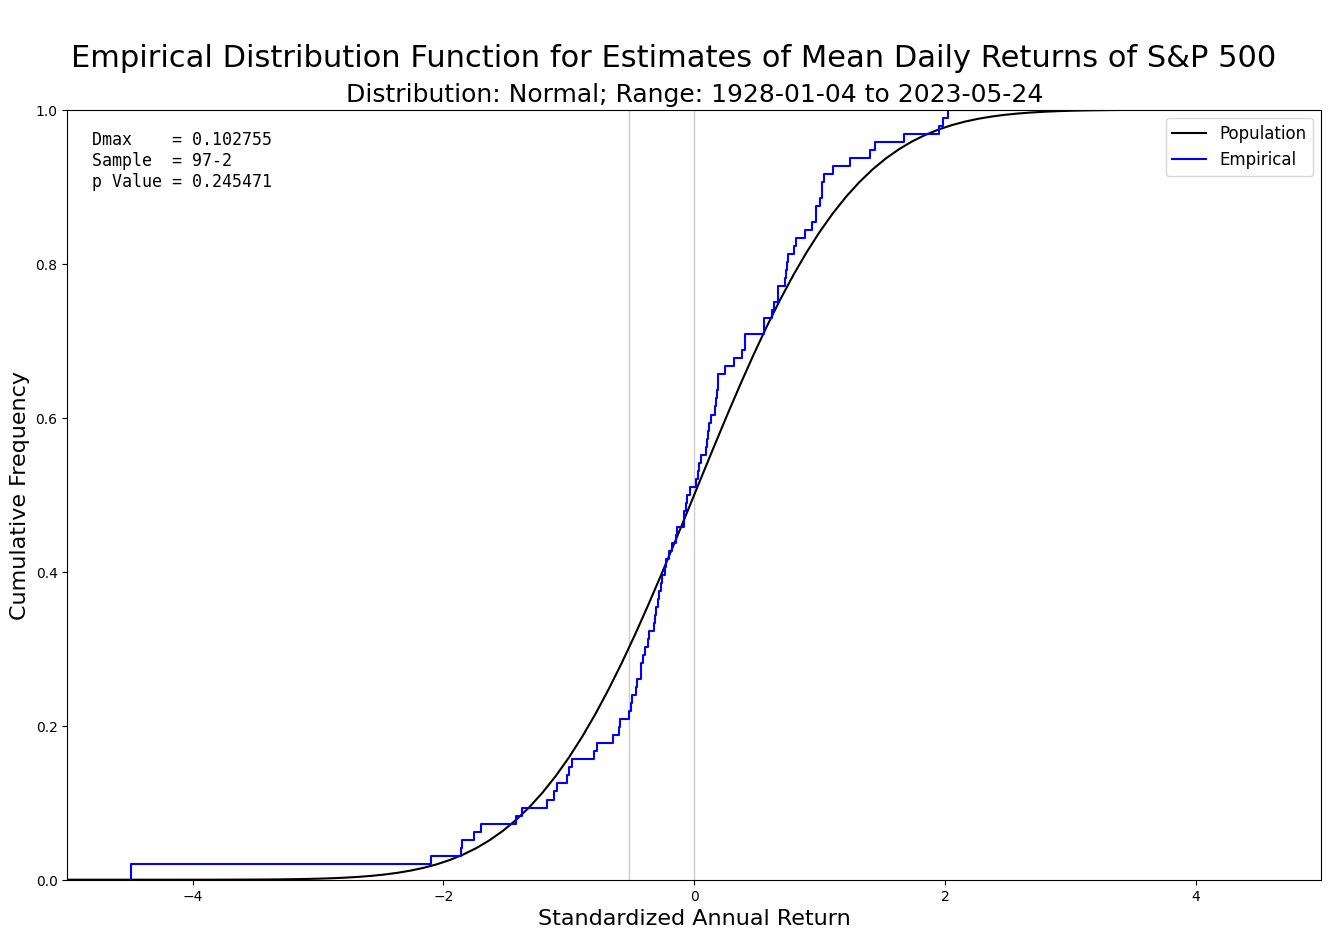

In [4]:
# Figure 2.13
from scipy.stats import norm,kstest
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
figure.suptitle("\nEmpirical Distribution Function for Estimates of Mean Daily Returns of S&P 500",fontsize=22)
plot.set_title("Distribution: Normal; Range: %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
x=np.linspace(-five,five,results.shape[0])
y=norm.cdf(x)
plot.plot(x,y,label='Population',color='black')
x=np.sort((results[('mu','value')]-results[('mu','value')].mean())/results[('mu','value')].std())
x=np.insert(x,0,min(x)) # extra point to complete the step plot
y=np.linspace(one/results.shape[0],one,results.shape[0])
y=np.insert(y,0,zero) # see above
plot.step(x,y,label='Empirical',color='blue')
ks=kstest(x[1:],'norm')
plot.axvline(ks.statistic_location,color='black',lw=1,alpha=0.2)
plot.text(-4.8,0.90,'Dmax    = %8.6f\nSample  = %d%+d\np Value = %8.6g' % (ks.statistic,len(x),-2,ks.pvalue),fontsize=12,fontdict={'family':'monospace'})
plot.axvline(zero,color='black',lw=1,alpha=0.2)
plot.set_ylabel("Cumulative Frequency",fontsize=16)
plot.set_xlabel("Standardized Annual Return",fontsize=16)
plot.set_xlim(-five,five)
plot.set_ylim(zero,one)
plot.legend(fontsize=12);

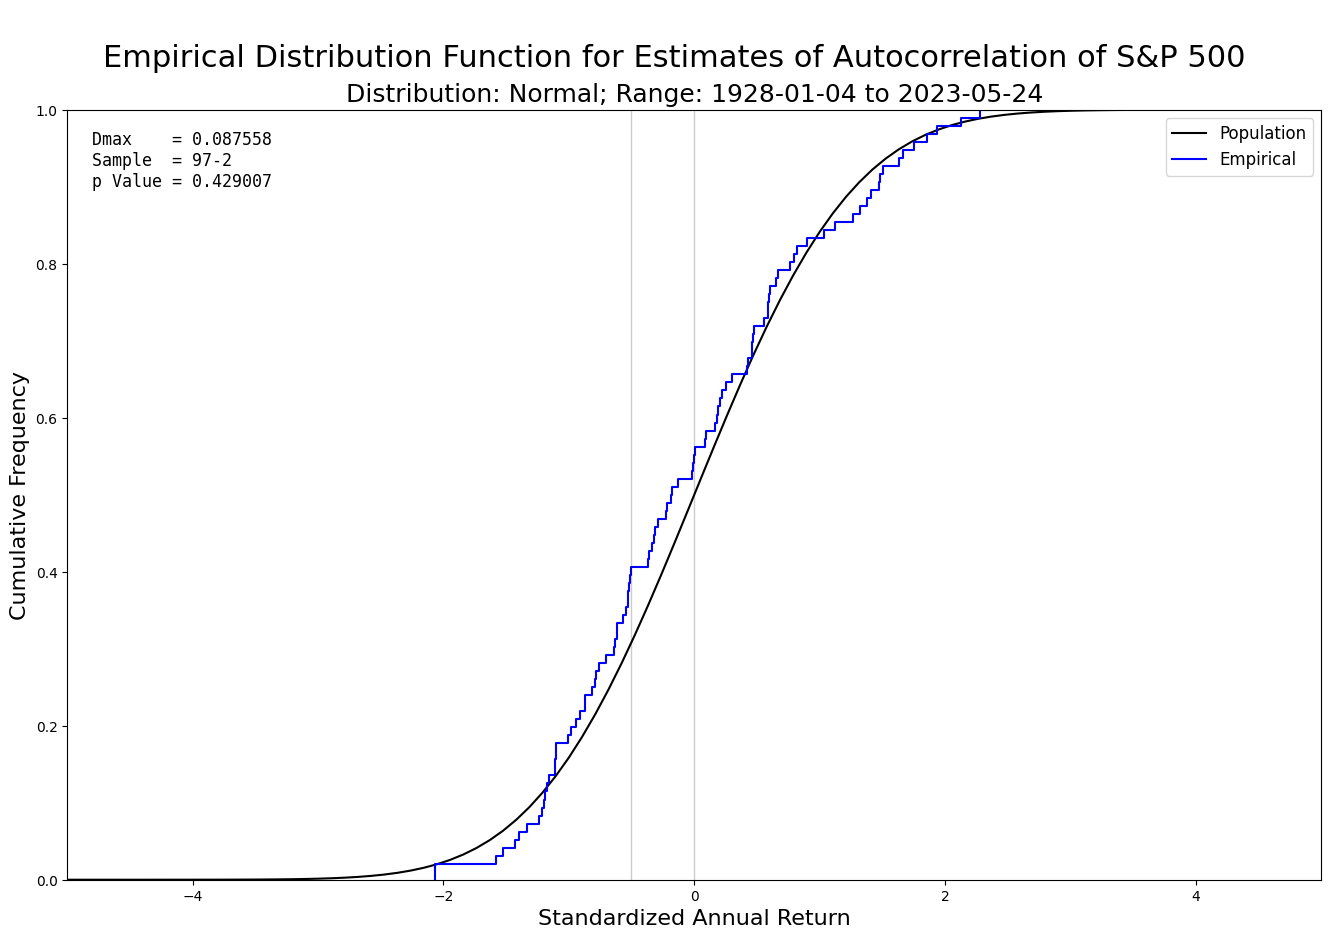

In [5]:
# Figure 2.14
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
figure.suptitle("\nEmpirical Distribution Function for Estimates of Autocorrelation of S&P 500",fontsize=22)
plot.set_title("Distribution: Normal; Range: %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
x=np.linspace(-five,five,results.shape[0])
y=norm.cdf(x)
plot.plot(x,y,label='Population',color='black')
x=np.sort((results[('phi','value')]-results[('phi','value')].mean())/results[('phi','value')].std())
x=np.insert(x,0,min(x)) # extra point to complete the step plot
y=np.linspace(one/results.shape[0],one,results.shape[0])
y=np.insert(y,0,zero) # see above
plot.step(x,y,label='Empirical',color='blue')
ks=kstest(x[1:],'norm')
plot.axvline(ks.statistic_location,color='black',lw=1,alpha=0.2)
plot.text(-4.8,0.90,'Dmax    = %8.6f\nSample  = %d%+d\np Value = %8.6g' % (ks.statistic,len(x),-2,ks.pvalue),fontsize=12,fontdict={'family':'monospace'})
plot.axvline(zero,color='black',lw=1,alpha=0.2)
plot.set_ylabel("Cumulative Frequency",fontsize=16)
plot.set_xlabel("Standardized Annual Return",fontsize=16)
plot.set_xlim(-five,five)
plot.set_ylim(zero,one)
plot.legend(fontsize=12);

In [6]:
# get the recessions data (NBER data at Fred) and perform ANOVA test onto estimates of mu
USREC=pd.read_table('https://fred.stlouisfed.org/data/USREC.txt',skiprows=65,sep=r'\s+',header=0).rename(columns={"VALUE":"USREC","DATE":"Date"}).set_index("Date")
USREC.index=pd.DatetimeIndex(USREC.index).to_period('M')
USREC['year']=USREC.index.year
any=USREC.groupby('year').max().rename(columns={"USREC":("Recession","any")})
any.columns=pd.MultiIndex.from_tuples(any.columns)
results=results.merge(any,left_index=True,right_index=True)
avg=USREC.groupby('year').mean().rename(columns={"USREC":("Recession","mean")})
avg.columns=pd.MultiIndex.from_tuples(avg.columns)
results=results.merge(avg,left_index=True,right_index=True)
results[["mu","phi","Recession"]]

mu                                      phi                       \
         value    stderr     tvalue    pvalue     value    stderr     tvalue   
year                                                                           
1928  0.213514  0.083036   2.571348  0.010130  0.045742  0.082376   0.555285   
1929  0.216353  0.002261  95.686747  0.000000 -0.053086  0.002360 -22.492603   
1930  0.112799  0.091797   1.228788  0.219151 -0.106647  0.063149  -1.688818   
1931 -0.326920  0.206822  -1.580688  0.113950 -0.132301  0.074201  -1.783014   
1932 -0.126057  0.202749  -0.621739  0.534113  0.023046  0.062911   0.366329   
...        ...       ...        ...       ...       ...       ...        ...   
2019  0.134167  0.041613   3.224138  0.001264 -0.054520  0.055505  -0.982268   
2020  0.251246  0.085197   2.949014  0.003188 -0.217372  0.097867  -2.221092   
2021  0.131102  0.040249   3.257251  0.001125 -0.022643  0.062938  -0.359771   
2022 -0.105478  0.099003  -1.065400  0.286695  0.024045  0.053857   0.446453   
2023  0.096266  0.084018   1.145785  0.251884 -0.111809  0.126307  -0.885214   

                    Recession            
             pvalue       any      mean  
year                                     
1928   5.786999e-01         0  0.000000  
1929  4.903731e-112         1  0.333333  
1930   9.125432e-02         1  1.000000  
1931   7.458410e-02         1  1.000000  
1932   7.141194e-01         1  1.000000  
...             ...       ...       ...  
2019   3.259680e-01         0  0.000000  
2020   2.634472e-02         1  0.166667  
2021   7.190183e-01         0  0.000000  
2022   6.552704e-01         0  0.000000  
2023   3.760414e-01         0  0.000000  

[96 rows x 10 columns]

In [7]:
# perform ANOVA on annual average daily return
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
design=results[[('mu','value'),('Recession','any')]]
design.columns=['Returns','Recession']
lm=ols('Returns ~ Recession',design).fit()
anova_lm(lm).fillna("")

,df,sum_sq,mean_sq,F,PR(>F)
Recession,1.0,0.014796,0.014796,2.126274,0.148125
Residual,94.0,0.654124,0.006959,,


In [8]:
# perform ANOVA on autocorrelation of daily returns
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
design=results[[('phi','value'),('Recession','any')]]
design.columns=['Autocorrelation','Recession']
lm=ols('Autocorrelation ~ Recession',design).fit()
anova_lm(lm).fillna("")

,df,sum_sq,mean_sq,F,PR(>F)
Recession,1.0,0.006567,0.006567,0.397014,0.530164
Residual,94.0,1.554777,0.016540,,


                            OLS Regression Results                            
Dep. Variable:                Returns   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     11.65
Date:                Wed, 24 May 2023   Prob (F-statistic):           0.000948
Time:                        20:38:48   Log-Likelihood:                 107.78
No. Observations:                  96   AIC:                            -211.6
Df Residuals:                      94   BIC:                            -206.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0650      0.009      7.017      0.0

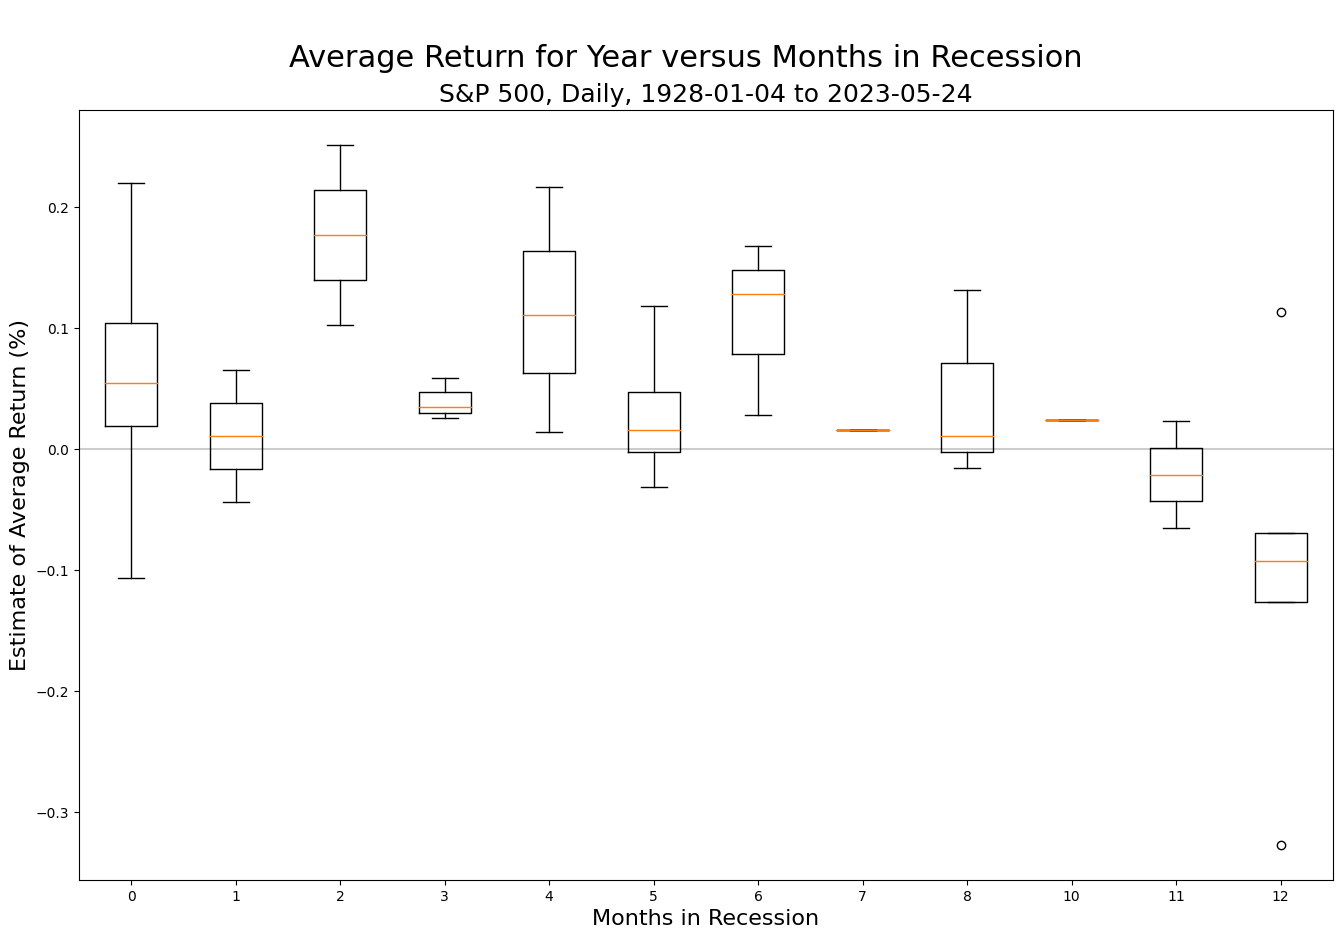

In [9]:
# bonus, regress mean daily return onto mean recession value
design=results[[('mu','value'),('Recession','mean')]]
design.columns=['Returns','Recession']
lm=ols('Returns ~ Recession',design).fit()
print(lm.summary())

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nAverage Return for Year versus Months in Recession",fontsize=22)
plot.set_title("S&P 500, Daily, %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
grouped=design.groupby("Recession")
plot.boxplot([grouped.get_group(x)["Returns"] for x in grouped.groups],labels=[str(int(12*k)) for k in grouped.groups])
plot.axhline(color='black',alpha=0.2)
plot.set_xlabel("Months in Recession",fontsize=16);
plot.set_ylabel("Estimate of Average Return (%)",fontsize=16);

                            OLS Regression Results                            
Dep. Variable:        Autocorrelation   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.2532
Date:                Wed, 24 May 2023   Prob (F-statistic):              0.616
Time:                        20:39:03   Log-Likelihood:                 61.613
No. Observations:                  96   AIC:                            -119.2
Df Residuals:                      94   BIC:                            -114.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0436      0.015      2.909      0.0

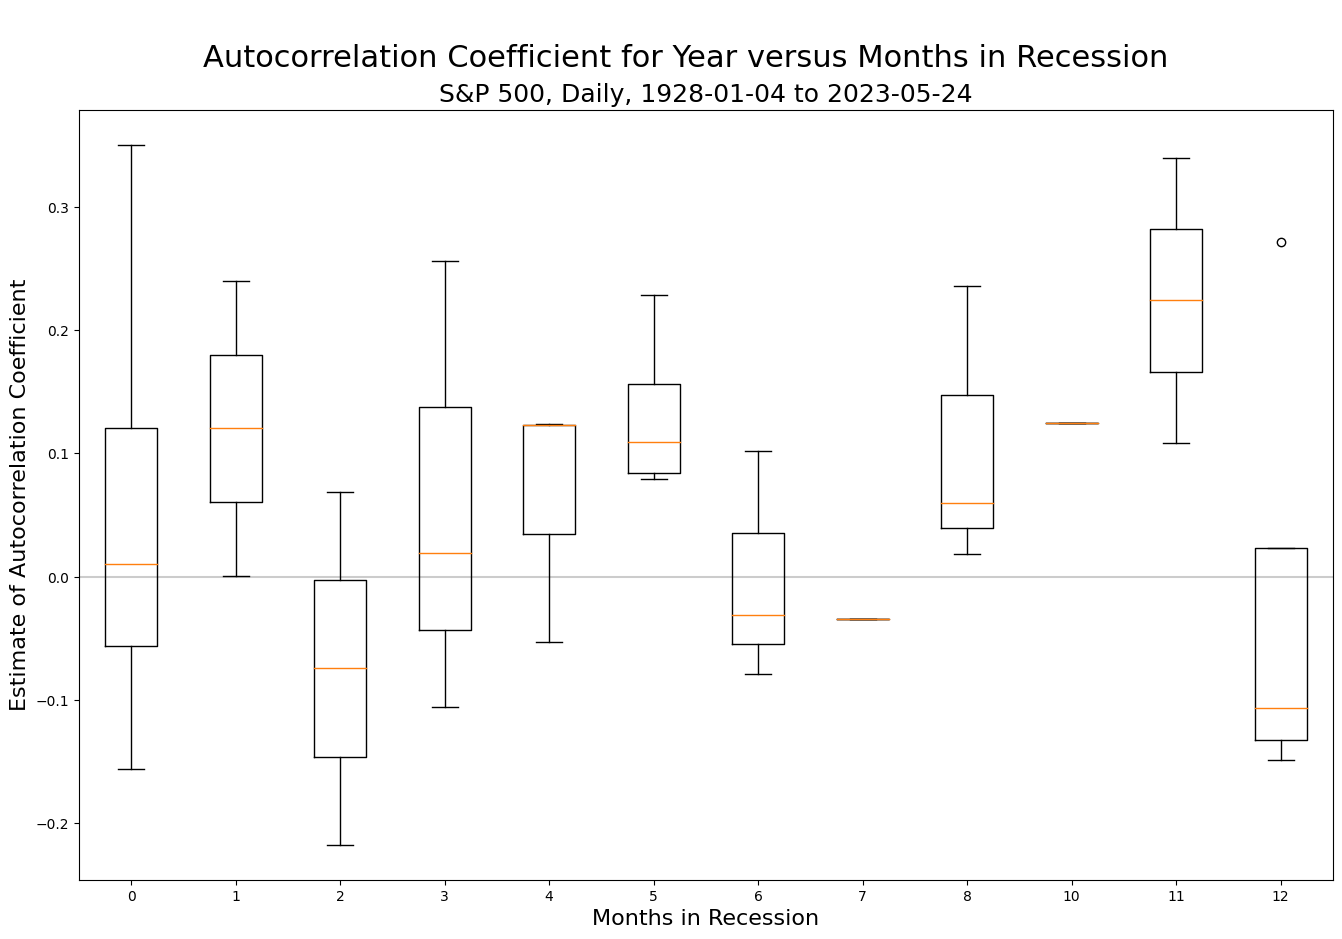

In [10]:
# bonus, regress autocorrelation coefficient onto mean recession value
design=results[[('phi','value'),('Recession','mean')]]
design.columns=['Autocorrelation','Recession']
lm=ols('Autocorrelation ~ Recession',design).fit()
print(lm.summary())

figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nAutocorrelation Coefficient for Year versus Months in Recession",fontsize=22)
plot.set_title("S&P 500, Daily, %s to %s" % (min(SPX.index),max(SPX.index)),fontsize=18)
grouped=design.groupby("Recession")
plot.boxplot([grouped.get_group(x)["Autocorrelation"] for x in grouped.groups],labels=[str(int(12*k)) for k in grouped.groups])
plot.axhline(color='black',alpha=0.2)
plot.set_xlabel("Months in Recession",fontsize=16);
plot.set_ylabel("Estimate of Autocorrelation Coefficient",fontsize=16);